In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

class NeuralNetwork:

    @staticmethod
    def sigma(x):
        return 1 / (np.exp(-x) + 1)

    @staticmethod
    def sigma_deriv(x):
        sig = NeuralNetwork.sigma(x)
        deriv = sig * (1 - sig)
        return deriv

    @staticmethod
    def softmax(x):
        # softmax function ---------
        t = np.exp(x - np.max(x))
        return t / np.sum(t, axis=1, keepdims=True)

    @staticmethod
    def get_activation_function(name):
        if name == 'sigma':
            return NeuralNetwork.sigma
        elif name == 'linear':
            return lambda x: x
        elif name == 'softmax':
            return NeuralNetwork.softmax
        elif name == 'tanh':
            return np.tanh
        elif name == 'relu':
            return lambda x: np.maximum(0, x)

    @staticmethod
    def get_activation_derivative(name):
        if name == 'sigma':
            return NeuralNetwork.sigma_deriv
        elif name == 'linear':
            return lambda x: np.ones_like(x)
        elif name == 'softmax':
            # jacobian of softmax - unused -------
            def softmax_deriv(x):
                value = NeuralNetwork.softmax(x)
                SM = value.reshape((-1, 1))
                jac = np.diagflat(value) - np.dot(SM, SM.T)
                return jac

            return softmax_deriv
        elif name == 'tanh':
            return lambda x: 1 - np.tanh(x)**2
        elif name == 'relu':
            return lambda x: x > 0


    @staticmethod
    def get_loss_function(name):
        if name == 'mse':
            return lambda x_pred, x: np.linalg.norm(x_pred - x)
        elif name == 'crossentropy':
            return lambda x_pred, x: -np.sum(x*np.log(x_pred))

    @staticmethod
    def get_loss_derivative(name):
        # currently unused
        if name == 'mse':
            return lambda x_pred, x: (x_pred - x)
        elif name == 'crossentropy':
            return lambda x_pred, x: x*(-1/x_pred)

    class Layer:
        def __init__(self, input_width, layer_width, activation_function):
            # self.weights = np.random.uniform(0, 1, (input_width + 1, layer_width))
            self.weights = np.random.normal(0, 1, (input_width + 1, layer_width))
            self.activation_function = activation_function

        def predict(self, x):
            activation_function = NeuralNetwork.get_activation_function(self.activation_function)
            return activation_function(np.dot(x, self.weights))

        def feedforward_step(self, x):
            activation_function = NeuralNetwork.get_activation_function(self.activation_function)
            activation = np.dot(x, self.weights)
            response = activation_function(activation)
            return response, activation

    def __init__(self, input_width, output_width, activation_function='sigma', loss_function='mse', bias_exists=True, seed=None):
        ###
        # create a new nn object. activation_function specifies activation used on hidden layers
        # loss_function affects loss printed to console
        ###
        self.input_width = input_width
        self.output_width = output_width
        self.layers = []
        self.activation_function = activation_function
        self.loss_function = NeuralNetwork.get_loss_function(loss_function)
        self.loss_derivative = NeuralNetwork.get_loss_derivative(loss_function)
        self.bias_exists = bias_exists
        self.seed = None

    def add_layer(self, layer_width):
        ###
        # add a hidden layer with specified number of neurons
        ###
        if len(self.layers) == 0:
            self.layers.append(NeuralNetwork.Layer(self.input_width, layer_width, self.activation_function))
        else:
            self.layers.append(
                NeuralNetwork.Layer(self.layers[-1].weights.shape[1], layer_width, self.activation_function))


    def predict(self, x):
        ###
        # predict responses on new data
        ###
        values = np.copy(x)
        for layer in self.layers:
            values = np.hstack((values, np.ones((values.shape[0], 1)) if self.bias_exists else np.zeros((values.shape[0], 1))))
            values = layer.predict(values)
        return values

    def create_output_layer(self, activation_function='linear'):
        ###
        # create output layer with specified activation function. Use after adding all hidden layers and before training
        ###
        if len(self.layers) == 0:
            self.layers.append(NeuralNetwork.Layer(self.input_width, self.output_width, activation_function))
        else:
            self.layers.append(
                NeuralNetwork.Layer(self.layers[-1].weights.shape[1], self.output_width, activation_function))

    def feedforward(self, x):
        response = np.copy(x)
        response = response.reshape(1, -1)
        response = np.hstack((response, np.ones((response.shape[0], 1))))
        response_s = [response]
        activation_s = []
        for i in range(len(self.layers) - 1):
            response, activation = self.layers[i].feedforward_step(response_s[i])
            activation_s.append(activation)
            response = response.reshape(1, -1)
            response = np.hstack((response, np.ones((response.shape[0], 1))))
            response_s.append(response)
        response, activation = self.layers[-1].feedforward_step(response_s[-1])
        activation_s.append(activation)
        response = response.reshape(1, -1)
        response_s.append(response)
        return (response_s, activation_s)

    def backpropagation(self, x, y, r_s, a_s):
        e_s = [None] * len(self.layers)

        ###
        # derivative of loss function in respect to final layer weights
        # assuming loss is crossentropy and output layer is softmax
        # formula is the same as in the case of linear outputs and mse
        ###
        e_s[-1] = a_s[-1] - y

        for i in reversed(range(1, len(e_s))):
            unbiased_weights = self.layers[i].weights[0:(self.layers[i].weights.shape[0] - 1), :]
            e_s[i-1] = NeuralNetwork.get_activation_derivative(self.layers[i-1].activation_function)(a_s[i-1])*(e_s[i].dot(unbiased_weights.T))
        gradient = [r_s[j].T.dot(e_s[j]) for j in range(0, len(self.layers))]
        return gradient

    def train(self, x, y, batch_size=10, epochs=100, lr=0.01, method='basic', method_param=0.0):
        ###
        # train network. method can be 'basic', 'momentum' or 'rmsprop'.
        # method_param specifies lambda in momentum or beta in rmsprop
        ###
        if self.seed is not None:
            np.random.seed(self.seed)
        errors = []
        eps = 1e-8
        momentum = [np.zeros(layer.weights.shape) for layer in self.layers]
        for e in range(epochs):
            permutation = np.random.permutation(y.shape[0])
            x = x[permutation, :]
            y = y[permutation, :]
            i = 0
            while i < y.shape[0]:
                deltas = [np.zeros(layer.weights.shape) for layer in self.layers]
                x_batch = x[i:i + batch_size, :]
                y_batch = y[i:i + batch_size, :]
                i = i + batch_size
                for j in range(0, y_batch.shape[0]):
                    r_s, a_s = self.feedforward(x_batch[j, :])
                    gradient = self.backpropagation(x_batch[j, :], y_batch[j, :], r_s, a_s)
                    for k in range(0, len(deltas)):
                        deltas[k] = deltas[k] - gradient[k]

                if method == 'momentum':
                    momentum = [delta + method_param * mom for mom, delta in zip(momentum, deltas)]
                elif method == 'rmsprop':
                    momentum = [method_param * mom + (1 - method_param)*np.square(delta) for mom, delta in zip(momentum, deltas)]

                for j in range(0, len(deltas)):
                    if method == 'momentum':
                        self.layers[j].weights = self.layers[j].weights + lr*momentum[j]
                    elif method == 'rmsprop':
                        self.layers[j].weights = self.layers[j].weights + lr * (deltas[j] / (np.sqrt(momentum[j]) + eps))
                    else:
                        self.layers[j].weights = self.layers[j].weights + lr*deltas[j]

                error = self.loss_function(self.predict(x_batch), y_batch)
                print("loss on batch = {}".format(error))
                errors.append(error)
        return errors


# TESTS ------------------------------------------------------------------------
# set path to dataset folders
classification = "projekt1/classification/"
regression = "projekt1/regression/"

# side functions

def nnerrors(inputw, outputw, activation, X, y, layers1, layers2, layers3, output_activation='linear', loss='mse', epochs=4):
    nn1 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers1:
        nn1.add_layer(layer)
    nn1.create_output_layer(output_activation)
    nn2 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers2:
        nn2.add_layer(layer)
    nn2.create_output_layer(output_activation)
    nn3 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers3:
        nn3.add_layer(layer)
    nn3.create_output_layer(output_activation)

    errors1 = nn1.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)
    errors2 = nn2.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)
    errors3 = nn3.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)

    return [errors1, errors2, errors3]


def make_plots(inputw, outputw, X, y, layers1, layers2, layers3, output_activation, loss, label1, label2, label3, suptitle, ylim=(0, 20), epochs=4):
    np.random.seed(42)
    sigma_error = nnerrors(inputw, outputw, 'sigma', X, y, layers1, layers2, layers3, output_activation, loss, epochs)
    tanh_error = nnerrors(inputw, outputw, 'tanh', X, y, layers1, layers2, layers3, output_activation, loss, epochs)
    relu_error = nnerrors(inputw, outputw, 'relu', X, y, layers1, layers2, layers3, output_activation, loss, epochs)

    x_err = range(len(sigma_error[0]))

    fig, axis = plt.subplots(1, 3, figsize=(10,5))
    plt.setp(axis, ylim=ylim)
    axis[0].plot(x_err, sigma_error[0], label=label1)
    axis[0].plot(x_err, sigma_error[1], label=label2)
    axis[0].plot(x_err, sigma_error[2], label=label3)
    axis[0].set_title('sigma')
    axis[0].set_ylabel(loss)
    axis[1].plot(x_err, tanh_error[0])
    axis[1].plot(x_err, tanh_error[1])
    axis[1].plot(x_err, tanh_error[2])
    axis[1].set_title('tanh')
    axis[2].plot(x_err, relu_error[0])
    axis[2].plot(x_err, relu_error[1])
    axis[2].plot(x_err, relu_error[2])
    axis[2].set_title('relu')
    fig.legend()
    fig.suptitle(suptitle)
    fig.show()

In [3]:
f = open(classification + "data.three_gauss.train.1000.csv")
gauss3train = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0, 1, 2))
f.close()
X_train = gauss3train[:, 0:2]
y_train = gauss3train[:, 2]
y_train = y_train.reshape(-1, 1)
encoder_gauss3 = OneHotEncoder(sparse=False)
y_gauss3train = encoder_gauss3.fit_transform(y_train)
X_gauss3train = X_train

f = open(classification + "data.three_gauss.test.1000.csv")
gauss3test = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0, 1, 2))
f.close()
X_test = gauss3test[:, 0:2]
y_test = gauss3test[:, 2]
y_test = y_test.reshape(-1, 1)
y_gauss3test = encoder_gauss3.transform(y_test)
X_gauss3test = X_test


loss on batch = 1315.9256161811454
loss on batch = 1184.3599066620118
loss on batch = 982.2583406484796
loss on batch = 887.9095855435913
loss on batch = 810.6580563415098
loss on batch = 718.2246748193818
loss on batch = 668.3472178022566
loss on batch = 622.5202171394513
loss on batch = 586.8742113690541
loss on batch = 559.4438134684247
loss on batch = 543.9240735063977
loss on batch = 541.7885593843018
loss on batch = 538.2429092535139
loss on batch = 539.7053344944242
loss on batch = 538.1553498077835
loss on batch = 537.3852713902163
loss on batch = 536.5332967239749
loss on batch = 529.3311549646568
loss on batch = 532.436304480181
loss on batch = 527.7532297217925
loss on batch = 523.0084449659341
loss on batch = 517.2045306787447
loss on batch = 516.9335646953903
loss on batch = 513.1401572250104
loss on batch = 513.6560107679752
loss on batch = 504.25252928247073
loss on batch = 502.6642354578779
loss on batch = 498.960805522825
loss on batch = 494.3167410022992
loss on batch

/home/pysiakk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


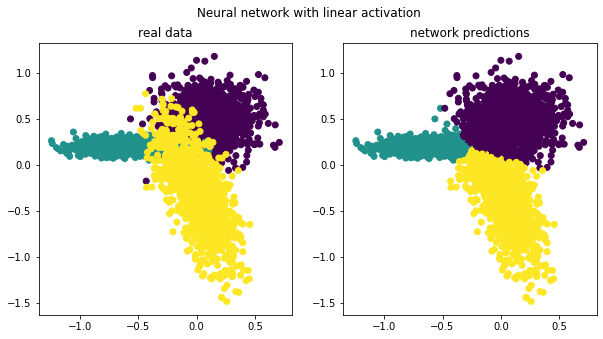

In [5]:
nn = NeuralNetwork(2, 3, loss_function='crossentropy')

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer('softmax')
nn.errors = nn.train(X_gauss3train, y_gauss3train, epochs=20, batch_size=500, lr=.05, method='rmsprop', method_param=0.2)
pred = nn.predict(X_gauss3test)

# Plot example
y = encoder_gauss3.inverse_transform(y_gauss3test)
y_pred = encoder_gauss3.inverse_transform(pred)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

axis[0].scatter(X_gauss3test[:,0].flatten(), X_gauss3test[:,1].flatten(), c = y.flatten())
axis[0].set_title('real data')
axis[1].scatter(X_gauss3test[:,0].flatten(), X_gauss3test[:,1].flatten(), c = y_pred.flatten())
axis[1].set_title('network predictions')
fig.suptitle('Neural network with linear activation')
fig.show()

In [52]:
f = open(regression + 'data.activation.train.10000.csv')
X, y = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0,1), unpack=True)
f.close()

X = (X-np.mean(X))/np.std(X)
y = (y-np.mean(y))/np.std(y)
X_activation_train = X.reshape(-1,1)
y_activation_train = y.reshape(-1,1)


f = open(regression + 'data.activation.test.10000.csv')
X, y = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0,1), unpack=True)
f.close()

X = (X-np.mean(X))/np.std(X)
y = (y-np.mean(y))/np.std(y)
X_activation_test = X.reshape(-1,1)
y_activation_test = y.reshape(-1,1)


In [61]:
nn = NeuralNetwork(1, 1)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer()
nn.errors = nn.train(X_activation_train, y_activation_train, epochs=5, batch_size=100, lr=.05, method='rmsprop', method_param=0.2)
pred = nn.predict(X_activation_test)

# Plot example


plt.scatter(X_activation_test.flatten(), y_activation_test.flatten(), label='real data')
plt.scatter(X_activation_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()


NameError: name 'X_activation_train' is not defined

In [47]:
data = pd.read_csv("projekt1/regression/data.activation.train.10000.csv")
X_train = np.array(data.iloc[:,:1])
y_train = np.array(data.iloc[:,1:])
data = pd.read_csv("projekt1/regression/data.activation.test.10000.csv")
X_test = np.array(data.iloc[:,:1])
y_test = np.array(data.iloc[:,1:])
X_test = (X_test - np.mean(X_train)) / np.std(X_train)
y_test = (y_test - np.mean(y_train)) / np.std(y_train)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
y_train = (y_train - np.mean(y_train)) / np.std(y_train)
print(X_train)
print(y_train)

[[-0.61804391]
 [ 0.63565033]
 [ 1.10413489]
 ...
 [-0.60777057]
 [-1.19618858]
 [-0.18647261]]
[[-0.45938957]
 [ 0.83263424]
 [ 0.95225293]
 ...
 [-0.44217055]
 [-1.40181267]
 [ 0.19361084]]


loss on batch = 9.835860157462625
loss on batch = 10.29003586516335
loss on batch = 10.383792722309913
loss on batch = 9.933817376977132
loss on batch = 9.139169411013942
loss on batch = 10.399410405966828
loss on batch = 10.312524265121615
loss on batch = 10.029878595783059
loss on batch = 10.130335134235175
loss on batch = 10.012554119443584
loss on batch = 10.43712837607196
loss on batch = 10.102730985354464
loss on batch = 9.998125559017842
loss on batch = 9.575055441729784
loss on batch = 10.204323627935398
loss on batch = 9.72382538349339
loss on batch = 10.33676427396978
loss on batch = 9.769773112023584
loss on batch = 10.372755032818459
loss on batch = 9.784040509065706
loss on batch = 9.521189229352991
loss on batch = 9.424752999765659
loss on batch = 10.841323800346109
loss on batch = 10.64469470024122
loss on batch = 9.649029205522092
loss on batch = 9.838115262151243
loss on batch = 9.274156525186804
loss on batch = 9.664376964726564
loss on batch = 9.537116665868037
loss 

loss on batch = 0.456494435112861
loss on batch = 0.48183097388210505
loss on batch = 0.4815954508631094
loss on batch = 0.4757187107270446
loss on batch = 0.5440675010583211
loss on batch = 0.4593591004430014
loss on batch = 0.4985238162252967
loss on batch = 0.49536068638424663
loss on batch = 0.5058965889522969
loss on batch = 0.48728717185552534
loss on batch = 0.48342825230574804
loss on batch = 0.4074157524649391
loss on batch = 0.4407076931844977
loss on batch = 0.4660037234029743
loss on batch = 0.5000677948118513
loss on batch = 0.4885866665338
loss on batch = 0.4078147721831538
loss on batch = 0.4862200123677463
loss on batch = 0.4887199029040354
loss on batch = 0.436129202976945
loss on batch = 0.4923790795818996
loss on batch = 0.43293286707937845
loss on batch = 0.4123703739201907
loss on batch = 0.4902933860237767
loss on batch = 0.4881940771648911
loss on batch = 0.4410577391549525
loss on batch = 0.4414595393405861
loss on batch = 0.4767786565266015
loss on batch = 0.42

loss on batch = 0.26520855696767565
loss on batch = 0.25486429150909323
loss on batch = 0.28832135612904136
loss on batch = 0.2879793660817922
loss on batch = 0.2664586653392008
loss on batch = 0.26465265479488165
loss on batch = 0.32872582498795794
loss on batch = 0.2884481857517256


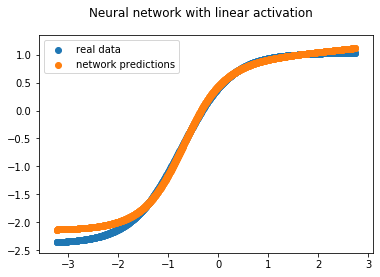

In [63]:
nn = NeuralNetwork(1, 1, activation_function="sigma", seed=123)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=100, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()


loss on batch = 14.275162280490939
loss on batch = 10.64913591200133
loss on batch = 10.385126983751867
loss on batch = 10.775803603559764
loss on batch = 9.753031312777246
loss on batch = 10.024478463484552
loss on batch = 9.422055677102977
loss on batch = 8.589471964471393
loss on batch = 9.911597803006918
loss on batch = 9.462726359428917
loss on batch = 8.799653841269006
loss on batch = 10.142691788221669
loss on batch = 9.428271167424663
loss on batch = 10.002404866964065
loss on batch = 9.103163735948051
loss on batch = 8.193586981454658
loss on batch = 8.209397528299615
loss on batch = 7.4274688315991195
loss on batch = 8.030154614532474
loss on batch = 7.282740584062241
loss on batch = 7.894575857203578
loss on batch = 7.020426767270974
loss on batch = 6.444469420420927
loss on batch = 6.139828527253165
loss on batch = 6.29390841054508
loss on batch = 5.794572021677253
loss on batch = 4.76234364119766
loss on batch = 4.8138474610867545
loss on batch = 5.318913924139934
loss on 

loss on batch = 3.2143691631048235
loss on batch = 3.7556519979518432
loss on batch = 3.0111843590000937
loss on batch = 3.789256308814529
loss on batch = 3.615542843085043
loss on batch = 5.080483834076847
loss on batch = 4.491701943913842
loss on batch = 6.494682602169039
loss on batch = 4.364937351269965
loss on batch = 5.2834053908212955
loss on batch = 4.776426129942024
loss on batch = 5.220458243955917
loss on batch = 4.286836439074606
loss on batch = 5.000962614790255
loss on batch = 4.05633172644786
loss on batch = 5.037316520177886
loss on batch = 3.4083909518436397
loss on batch = 3.8337060533087643
loss on batch = 3.1718258190949973
loss on batch = 3.9444179165180318
loss on batch = 3.4854617682786957
loss on batch = 4.3083128753106426
loss on batch = 4.288329665357786
loss on batch = 5.6181000487505495
loss on batch = 3.9768445576170857
loss on batch = 4.3076770524098364
loss on batch = 3.350084038287853
loss on batch = 3.365240602115591
loss on batch = 3.4686879707858207
l

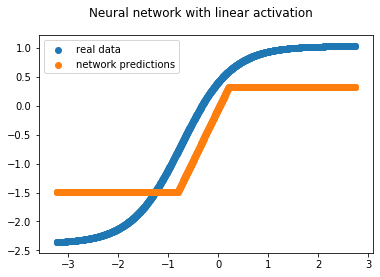

In [58]:
nn = NeuralNetwork(1, 1, activation_function="relu", seed=123)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=100, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

loss on batch = 5.121822903132668
loss on batch = 3.3565000862032903
loss on batch = 2.16703502457034
loss on batch = 2.0962109928123236
loss on batch = 1.6533172372591767
loss on batch = 1.2599132884028357
loss on batch = 1.198131201154848
loss on batch = 1.413514398036614
loss on batch = 1.3394316707865075
loss on batch = 1.1623300682878868
loss on batch = 1.1544247860089873
loss on batch = 1.1615885613736012
loss on batch = 1.006618445222735
loss on batch = 0.9970129153000505
loss on batch = 1.0162314318965826
loss on batch = 0.9332301211919402
loss on batch = 0.7949093505621981
loss on batch = 0.9154701991391492
loss on batch = 0.8613923483025999
loss on batch = 0.8896716979681495
loss on batch = 0.8781246603204627
loss on batch = 0.780486453149631
loss on batch = 0.7486726064924967
loss on batch = 0.8163399347446595
loss on batch = 0.7195327962018777
loss on batch = 0.7203238381902816
loss on batch = 0.8377513165324127
loss on batch = 0.6493516506015271
loss on batch = 0.741772330

loss on batch = 0.30444389708016967
loss on batch = 0.30514836673242135
loss on batch = 0.30996722550589617
loss on batch = 0.32498795738220415
loss on batch = 0.3272130971040201
loss on batch = 0.37058304714344237
loss on batch = 0.42897503582005775
loss on batch = 0.5354699582200219
loss on batch = 0.6271560765015493
loss on batch = 0.7376841024590307
loss on batch = 0.855180531916338
loss on batch = 0.7194112953206891
loss on batch = 1.0006648659172144
loss on batch = 1.2621518531931504
loss on batch = 1.1191154231518532
loss on batch = 0.9302123670689834
loss on batch = 1.0577639215342296
loss on batch = 1.0625569357176918
loss on batch = 0.802480099799255
loss on batch = 0.7546870448963906
loss on batch = 0.695177621926206
loss on batch = 0.8710932932800708
loss on batch = 0.7747374764686978
loss on batch = 0.8626358005354733
loss on batch = 0.9723797360517504
loss on batch = 0.6844879596743473
loss on batch = 0.7932946317094762
loss on batch = 0.8302911857112908
loss on batch = 0

loss on batch = 0.38848303353272684
loss on batch = 0.36501228895069304
loss on batch = 0.3786147686618678
loss on batch = 0.35773015604158254
loss on batch = 0.2769500822124209
loss on batch = 0.3168227794252224
loss on batch = 0.2914145397885694
loss on batch = 0.36326271986548037
loss on batch = 0.2910596528156557
loss on batch = 0.2634719407437682
loss on batch = 0.35015795442793635
loss on batch = 0.4556327042095895
loss on batch = 0.4959663944889137
loss on batch = 0.6306541788556543
loss on batch = 0.6301297948486241
loss on batch = 0.5446250198920994
loss on batch = 0.6128340760204918
loss on batch = 0.6315472711991106
loss on batch = 0.5388529846853248
loss on batch = 0.5247874845163034
loss on batch = 0.4790782741372407
loss on batch = 0.4417498341338097


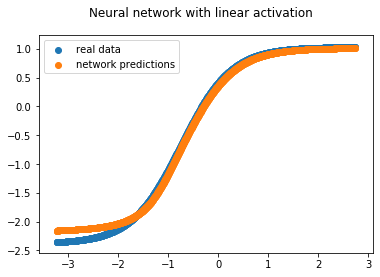

In [59]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=123)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=100, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()